In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import f1_score


# Read the Data :

In [ ]:

drive.mount('/content/drive')
final_data=pd.read_csv("/content/drive/MyDrive/Portfolio/Credit Score Classification (Classification)/Data/final_data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96323 entries, 0 to 96322
Data columns (total 61 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Age                                                 96323 non-null  float64
 1   Annual_Income                                       96323 non-null  float64
 2   Monthly_Inhand_Salary                               96323 non-null  float64
 3   Num_Bank_Accounts                                   96323 non-null  float64
 4   Num_Credit_Card                                     96323 non-null  float64
 5   Interest_Rate                                       96323 non-null  float64
 6   Num_of_Loan                                         96323 non-null  float64
 7   Delay_from_due_date                                 96323 non-null  float64
 8   Num_of_Delayed_Payment                              96323 non-null  float64


In [ ]:
final_data.dropna().shape

(96323, 61)

In [ ]:



def plot_multiclass_roc_curve(y_true, y_score, n_classes, title='Multiclass ROC Curve'):
    # Binarize the output
    y_test_bin = label_binarize(y_true, classes=[i for i in range(n_classes)])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))

    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


In [ ]:

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    # Convert one-hot encoded predictions to categorical labels
    y_pred_categorical = np.argmax(y_pred, axis=1)
    y_true_categorical = np.argmax(y_true, axis=1)

    cm = confusion_matrix(y_true_categorical, y_pred_categorical)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


# Split the Data into Trainng & Tetsing Sets :

In [ ]:


def data_split(data, target_column, test_size=0.2, random_state=42):

    # One-hot encode the categorical target variable
    target = pd.get_dummies(data[target_column])
    columns_to_scale = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Outstanding_Debt','Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                    'Amount_invested_monthly', 'Monthly_Balance']

    scaler = StandardScaler()
    data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])



    # Drop the original target column from the features
    features = data.drop(columns=[target_column])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)

    # Convert target variables to categorical
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    X_train=X_train.to_numpy()
    X_test=X_test.to_numpy()

    return X_train, X_test, y_train, y_test


Y='Credit_Score'

X_train, X_test, y_train, y_test=data_split(final_data,Y, random_state=42)

In [ ]:
X_train.shape

(77058, 60)

In [ ]:
y_train.shape

(77058, 3)

#  1 . XGBoost Classifier :

In [ ]:
model_xgb = XGBClassifier(learning_rate=0.1, n_estimators=300, max_depth=20,tree_method='hist')
model_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Make predictions on the test data
y_pred_xgb = model_xgb.predict(X_test)



F1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
xgb_overall_accuracy = accuracy_score(y_test, y_pred_xgb)

print(f"Accuracy of XGBOOST model :  {xgb_overall_accuracy:.2f} %")
print(f"-----------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred_xgb))

Accuracy of XGBOOST model :  0.77 %
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      3369
           1       0.81      0.82      0.81      5698
           2       0.86      0.80      0.83     10198

   micro avg       0.83      0.79      0.81     19265
   macro avg       0.82      0.79      0.80     19265
weighted avg       0.83      0.79      0.81     19265
 samples avg       0.78      0.79      0.79     19265



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


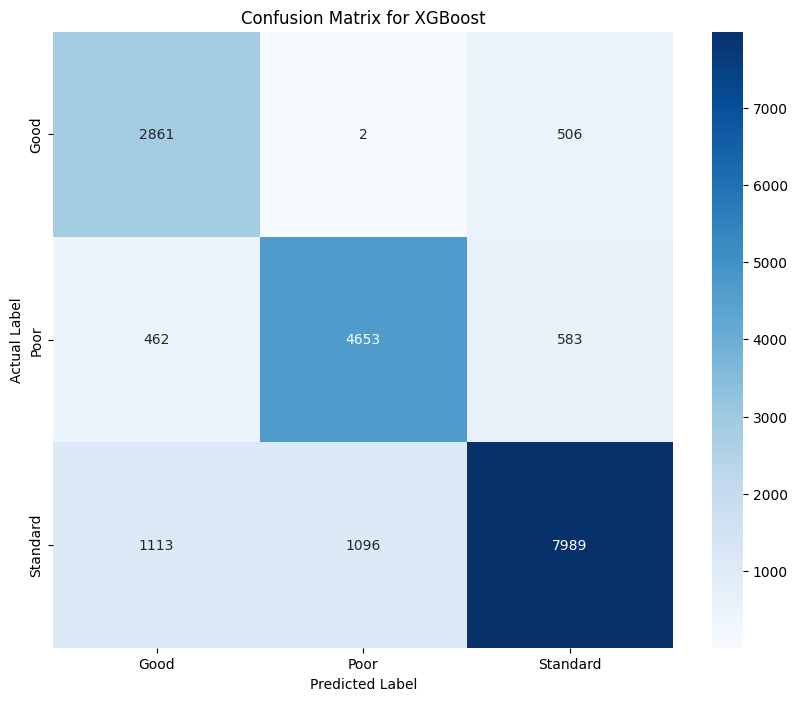

In [ ]:
credit_score_labels = [ "Good", "Poor","Standard"]

plot_confusion_matrix(y_test, y_pred_xgb, labels=credit_score_labels, title='Confusion Matrix for XGBoost')

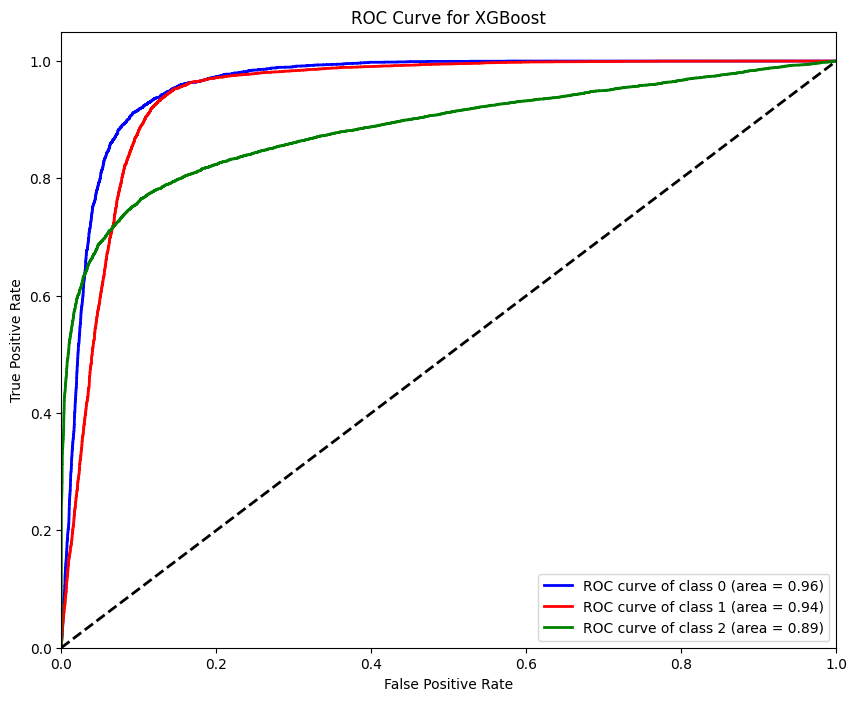

In [ ]:
y_pred_xgb_proba = model_xgb.predict_proba(X_test)

n_classes = y_test.shape[1]


plot_multiclass_roc_curve(np.argmax(y_test, axis=1), y_pred_xgb_proba, n_classes=n_classes, title='ROC Curve for XGBoost')

#**2. Random Forest Classifie**r :

In [ ]:

# Create the RandomForestClassifier model with your specified parameters
rf = RandomForestClassifier(
    ccp_alpha=0.0,
    class_weight=None,
    criterion='gini',
    max_depth=None,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    random_state=72
)

# Fit the model to the training data
rf.fit(X_train, y_train)


Overall Accuracy of Random Forest : 0.79 %
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      3369
           1       0.80      0.82      0.81      5698
           2       0.86      0.79      0.82     10198

   micro avg       0.83      0.79      0.81     19265
   macro avg       0.82      0.78      0.80     19265
weighted avg       0.83      0.79      0.81     19265
 samples avg       0.79      0.79      0.79     19265



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

# Make predictions on the test data
y_pred_rf = rf.predict(X_test)

# Print the classification report to evaluate the model's performancefrom sklearn.metrics import accuracy_score

# Assuming y_test and y_pred_rf contain the true labels and predicted labels, respectively
rf_overall_accuracy = accuracy_score(y_test, y_pred_rf)


F1_rf = f1_score(y_test, y_pred_xgb, average='weighted')



print(f"Overall Accuracy of Random Forest : {rf_overall_accuracy:.2f} %")
print(f"-----------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred_rf))

Overall Accuracy of Random Forest : 0.79 %
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      3369
           1       0.80      0.82      0.81      5698
           2       0.86      0.79      0.82     10198

   micro avg       0.83      0.79      0.81     19265
   macro avg       0.82      0.78      0.80     19265
weighted avg       0.83      0.79      0.81     19265
 samples avg       0.79      0.79      0.79     19265



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


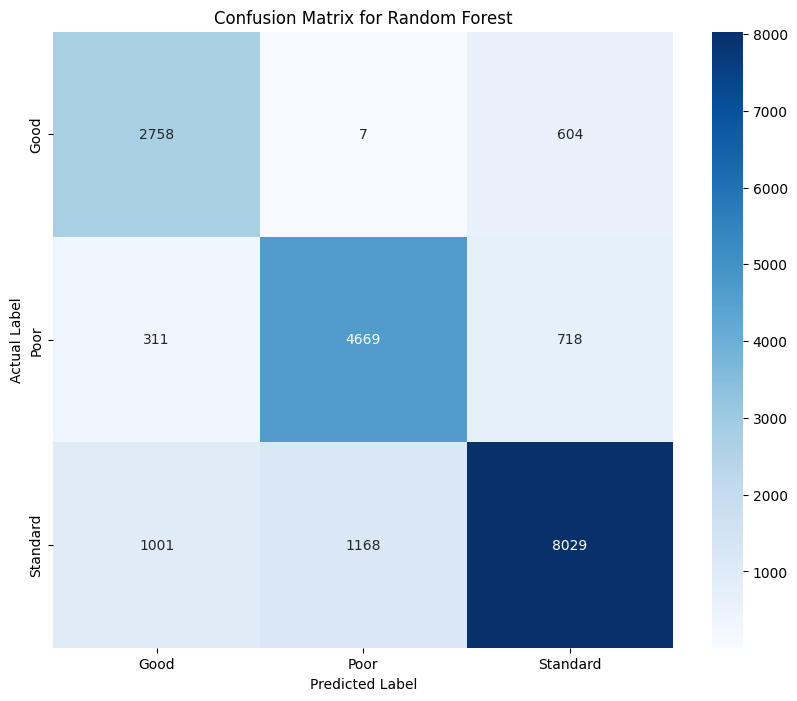

In [ ]:
credit_score_labels = [ "Good", "Poor","Standard"]

plot_confusion_matrix(y_test, y_pred_rf, labels=credit_score_labels, title='Confusion Matrix for Random Forest')

In [ ]:
y_pred_rf_proba = rf.predict_proba(X_test)
y_pred_rf_proba_combined = np.array([probs[:, 1] for probs in y_pred_rf_proba]).T
n_classes = y_test.shape[1]



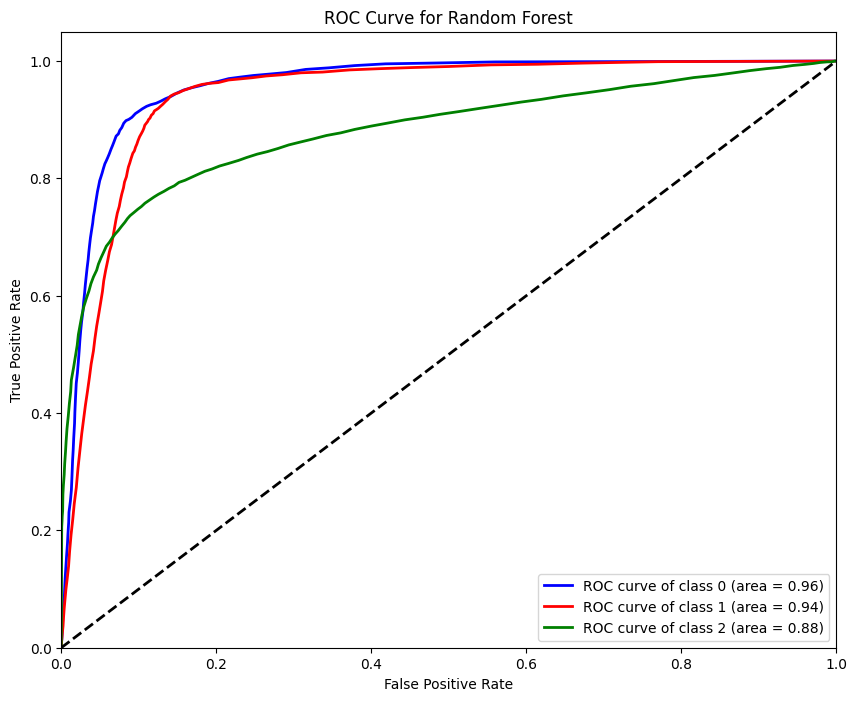

In [ ]:

plot_multiclass_roc_curve(np.argmax(y_test, axis=1), y_pred_rf_proba_combined, n_classes=n_classes, title='ROC Curve for Random Forest')

#**3.  Neural Networks Classifie**r :    

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_11 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(60,)),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(3, activation="softmax")
])


In [ ]:
from keras import backend as K

def F1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
model_11.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1])


In [ ]:
#add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8)


In [ ]:

#add  learning rate reduction callbcack
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


In [ ]:
history = model_11.fit(X_train, y_train,
                       epochs=100,
                       validation_data=(X_test, y_test),
                       callbacks=[early_stopping, lr_reduction])


Epoch 1/100
2409/2409 [==============================] - 26s 7ms/step - loss: 0.7103 - accuracy: 0.6749 - precision: 0.7240 - recall: 0.5936 - F1: 0.6505 - val_loss: 0.7022 - val_accuracy: 0.6856 - val_precision: 0.7271 - val_recall: 0.6254 - val_F1: 0.6722 - lr: 0.0010
Epoch 2/100
2409/2409 [==============================] - 16s 7ms/step - loss: 0.6659 - accuracy: 0.6958 - precision: 0.7427 - recall: 0.6223 - F1: 0.6760 - val_loss: 0.6656 - val_accuracy: 0.6954 - val_precision: 0.7541 - val_recall: 0.5928 - val_F1: 0.6631 - lr: 0.0010
Epoch 3/100
2409/2409 [==============================] - 16s 7ms/step - loss: 0.6515 - accuracy: 0.7024 - precision: 0.7457 - recall: 0.6330 - F1: 0.6835 - val_loss: 0.6916 - val_accuracy: 0.6595 - val_precision: 0.7108 - val_recall: 0.5696 - val_F1: 0.6318 - lr: 0.0010
Epoch 4/100
2409/2409 [==============================] - 17s 7ms/step - loss: 0.6426 - accuracy: 0.7059 - precision: 0.7438 - recall: 0.6445 - F1: 0.6896 - val_loss: 0.6572 - val_accuracy

In [ ]:
model_evaluation = model_11.evaluate(X_test, y_test)
F1_NN=model_evaluation[-1]
accuracy_NN=model_evaluation[1]
F1_NN,accuracy_NN

603/603 [==============================] - 4s 6ms/step - loss: 0.6950 - accuracy: 0.7358 - precision: 0.7414 - recall: 0.7281 - F1: 0.7350


(0.7349703907966614, 0.7357903122901917)

In [ ]:
# Make predictions
y_pred_probs = model_11.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=[ "Good", "Poor","Standard"]))

603/603 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

        Good       0.68      0.65      0.67      3369
        Poor       0.73      0.71      0.72      5698
    Standard       0.75      0.78      0.77     10198

    accuracy                           0.74     19265
   macro avg       0.72      0.71      0.72     19265
weighted avg       0.74      0.74      0.74     19265



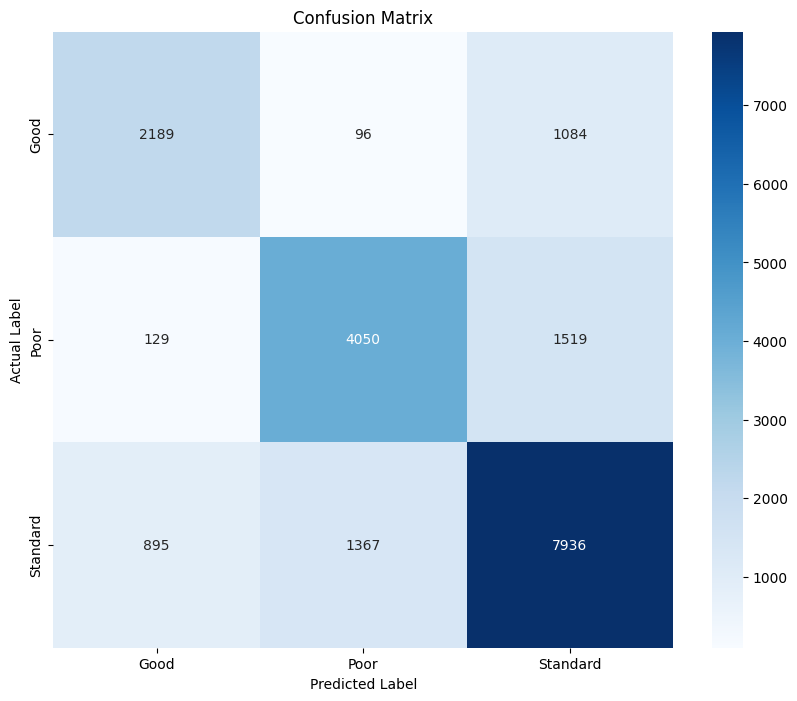

In [ ]:
plot_confusion_matrix(y_test, y_pred_probs, labels=["Good", "Poor","Standard"], title='Confusion Matrix')

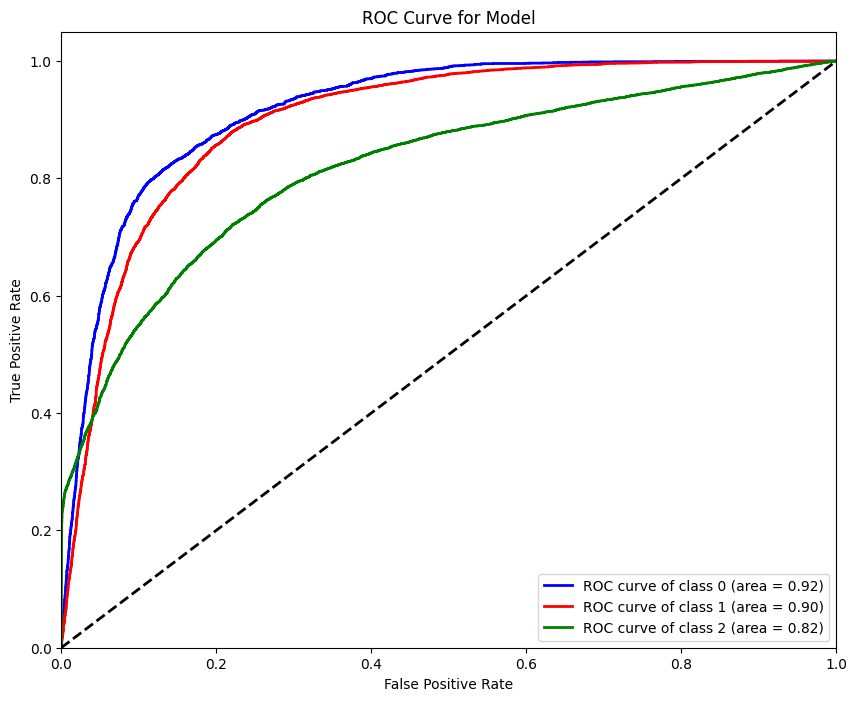

In [ ]:

plot_multiclass_roc_curve(y_true, y_pred_probs, n_classes=n_classes, title='ROC Curve for Neural Network')


#  Models Comparison :

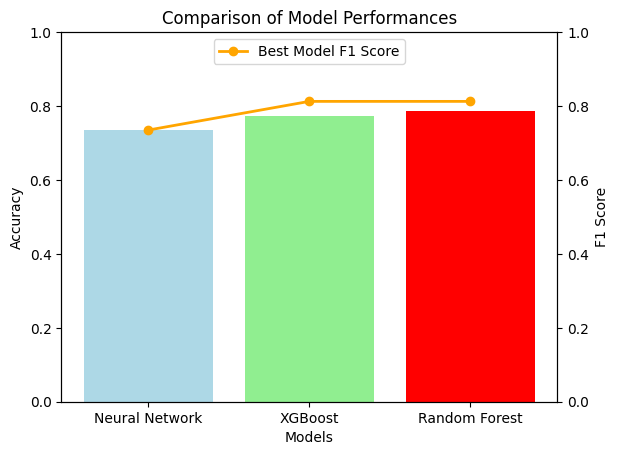

In [ ]:
models = ['Neural Network', 'XGBoost', 'Random Forest']
accuracies = [accuracy_NN, xgb_overall_accuracy, rf_overall_accuracy]

# Plotting
fig, ax = plt.subplots()
bars = ax.bar(models, accuracies, color=['lightblue', 'lightgreen', 'red'])

# Adding the F1 score as a line
ax2 = ax.twinx()
ax2.plot(models, [F1_NN, F1_xgb, F1_rf], color='orange', marker='o', linestyle='-', linewidth=2, label='Best Model F1 Score')

# Setting the y-axis limits to be the same for both accuracy and F1 score
ax.set_ylim(0, 1)
ax2.set_ylim(0, 1)

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax2.set_ylabel('F1 Score')
plt.title('Comparison of Model Performances')

# Show legend
ax2.legend(loc='upper center')

plt.show()

# Hyper parameters Tuning :    

## Fine Tuned XGBoost :

In [ ]:
## Run this code to obtain best parms for XGBoost and Random forest
## Ps : This will take a while .....


In [ ]:

param_grid = {
    'n_estimators': [100,500,800],
    'learning_rate': [0.1,0.01],
    'max_depth': [8,16,None],
    'tree_method': ['hist']

}
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"best params For XGBoost : {best_params}")

best_model_xgb = grid_search.best_estimator_

y_pred_xgb_ft = best_model_xgb.predict(X_test)

accuracy_xgb_ft = accuracy_score(y_test, y_pred_xgb_ft)
print(f"Accuracy of Fine tuned Xgb: {accuracy_xgb_ft:.2f} %")
print(f"-----------------------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred_xgb_ft))

## Fine Tuned Random Forest :

In [ ]:

# Define a more comprehensive hyperparameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini','entropy','log_loss' ],
    'max_depth': [10,20,None],

}

# Create GridSearchCV with the initial model and the comprehensive hyperparameter grid
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and best model from GridSearchCV
best_params_rf = grid_search.best_params_
best_model_rf = grid_search.best_estimator_
print(f"Best Parameters for  Random Forest: {best_params_rf}")

# Predict and calculate accuracy for the best model
y_pred_best_rf = best_model_rf.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"Accuracy of Fine-Tuned  Random Forest model: {accuracy_best_rf}")
